# Imports

In [99]:
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
import scipy as sp
import hvplot.pandas
import numpy as np
import holoviews as hv
import matplotlib

## Load TSM RS data

In [230]:
paths = list(Path('validation').glob(f'rrs_main_timeseries_siwrp_12122023.csv'))
path_csv = paths[0]
df_rs = pd.read_csv(path_csv, dtype={'station_id':str})
df_rs['dt_utc'] = pd.to_datetime(df_rs['system:time_start'], format='mixed', utc=True)
df_rs['dt_loc'] = df_rs['dt_utc'].dt.tz_convert('Asia/Ho_Chi_Minh')
df_rs['date'] = df_rs['dt_loc'].dt.date
df_rs = df_rs.drop(columns=['.geo', 'system:time_start'], errors='ignore')
df_rs = df_rs.sort_values('date')
df_rs['data_source'] = 'siwrp'
df_rs_siwrp = df_rs.loc[df_rs.station_id.isin(['chaudoc', 'tanchau', 'vamnao', 'mythuan', 'cantho'])]
print(f'Loaded "{path_csv}" file.')

Loaded "validation\rrs_main_timeseries_siwrp_12122023.csv" file.


In [231]:
# paths = list(Path('validation').glob(f'sr_timeseries_mrc.csv'))
# path_csv = paths[0]
# df_rs = pd.read_csv(path_csv, dtype={'station_id':str})
# df_rs['dt_utc'] = pd.to_datetime(df_rs['system:time_start'], format='mixed', utc=True)
# df_rs['dt_loc'] = df_rs['dt_utc'].dt.tz_convert('Asia/Ho_Chi_Minh')
# df_rs['date'] = df_rs['dt_loc'].dt.date
# df_rs = df_rs.drop(columns=['.geo', 'system:time_start'], errors='ignore')
# df_rs = df_rs.sort_values('date')
# df_rs['data_source'] = 'mrc'
# df_rs_mrc = df_rs
# print(f'Loaded "{path_csv}" file.')

In [232]:
#df_rs = pd.concat([df_rs_siwrp, df_rs_mrc])
df_rs = df_rs_siwrp

## Load TSM insitu data

In [233]:
# read SIWRP files
path_metadata = 'data/insitu_siwrp/Tss_LongDataset_VMD.xlsx'
df_metadata = pd.read_excel(path_metadata, sheet_name=1)
df_metadata['station_id'] = df_metadata['Station'].apply(lambda x: x.replace(" ", "").lower())
path_data = 'data/insitu_siwrp/siwrp_data.csv'
df_insitu_siwrp = pd.read_csv(path_data, parse_dates=['date', 'dt_loc_estimated'])
df_insitu_siwrp = df_insitu_siwrp.rename(columns={'dt_loc_estimated': 'dt_loc'})
df_insitu_siwrp['date'] = df_insitu_siwrp['date'].dt.date
df_insitu = df_insitu_siwrp.sort_values('date')

print(f'Loaded "{path_data}" file.')

Loaded "data/insitu_siwrp/siwrp_data.csv" file.


In [234]:
df_insitu_minmax = df_insitu.groupby(['date', 'station_id']).agg({"value": [np.max, np.min]}).reset_index()
df_insitu_minmax.columns = list(map(''.join, df_insitu_minmax.columns.values))

df_insitu_minmax.hvplot.area(x='date', ylabel='TSM (mg/L)', y='valueamin', y2='valueamax', groupby='station_id')

:DynamicMap   [station_id]
   :Area   [date]   (valueamin,valueamax)

### Get matchups

In [294]:
import datetime

delta_dt = 12 # allowed timedifference in hours
df_rs = df_rs.reset_index().drop(columns=['index'])

n_matchups = 0
for idx, row in df_rs.iterrows():
    station_id = row.station_id
    timestamp = row.dt_loc
    t_start = timestamp - datetime.timedelta(hours=delta_dt)
    t_end = timestamp + datetime.timedelta(hours=delta_dt)
    matches = df_insitu.loc[(df_insitu.dt_loc <= t_end) & (df_insitu.dt_loc >= t_start)]
    matches = matches.loc[matches.station_id == station_id]
    
    if matches.shape[0] == 0:
        value = np.nan
        dt_loc_insitu = pd.Timestamp('NaT')
        dt_diff = pd.Timestamp('NaT')
    elif matches.shape[0] == 1:
        value = matches.iloc[0].value
        dt_loc_insitu = matches.iloc[0].dt_loc
        dt_diff = abs(matches.iloc[0]['dt_loc']-timestamp)
        n_matchups += 1
    else:
        matches['dt_diff'] = abs(matches['dt_loc']-timestamp)
        matches = matches.sort_values('dt_diff')
        value = matches.iloc[0].value 
        dt_loc_insitu = matches.iloc[0].dt_loc
        dt_diff = matches.iloc[0].dt_diff
        n_matchups += 1
    
    df_rs.loc[idx, 'value'] = value
    df_rs.loc[idx, 'dt_loc_insitu'] = dt_loc_insitu
    df_rs.loc[idx, 'dt_diff'] = dt_diff

print(f'{n_matchups} ({(n_matchups/df_rs.shape[0])*100:0.1f}%) matchups found with maximal difference of {delta_dt} hours.')

2091 (99.8%) matchups found with maximal difference of 12 hours.


# Plot regression for all datapoints

In [236]:
df_rs.columns.values

array(['system:index', 'B10_max', 'B10_mean', 'B10_median', 'B10_min',
       'B10_stdDev', 'B1_max', 'B1_mean', 'B1_median', 'B1_min',
       'B1_stdDev', 'B2_max', 'B2_mean', 'B2_median', 'B2_min',
       'B2_stdDev', 'B3_max', 'B3_mean', 'B3_median', 'B3_min',
       'B3_stdDev', 'B4_max', 'B4_mean', 'B4_median', 'B4_min',
       'B4_stdDev', 'B5_max', 'B5_mean', 'B5_median', 'B5_min',
       'B5_stdDev', 'B6_max', 'B6_mean', 'B6_median', 'B6_min',
       'B6_stdDev', 'B7_max', 'B7_mean', 'B7_median', 'B7_min',
       'B7_stdDev', 'B8A_max', 'B8A_mean', 'B8A_median', 'B8A_min',
       'B8A_stdDev', 'B8_max', 'B8_mean', 'B8_median', 'B8_min',
       'B8_stdDev', 'B9_max', 'B9_mean', 'B9_median', 'B9_min',
       'B9_stdDev', 'CLOUD_COVER', 'add_ndssi_max', 'add_ndssi_mean',
       'add_ndssi_median', 'add_ndssi_min', 'add_ndssi_stdDev',
       'add_nsmi_max', 'add_nsmi_mean', 'add_nsmi_median', 'add_nsmi_min',
       'add_nsmi_stdDev', 'add_ratio_bn_max', 'add_ratio_bn_mean',
       

In [381]:
sensor = 'ALL'    # Set sensor (OLI/MSI/ALL)
metric = 'B4_mean' # Set metric

# Set thresholds
thresh_cloud_cover = 85
thresh_roi_coverage = 90

if sensor == 'OLI':
    platforms = ['LANDSAT-8', 'LANDSAT-9']
elif sensor == 'MSI':
    platforms = ['SENTINEL-2']
elif sensor == 'ALL':
    platforms = ['LANDSAT-8', 'LANDSAT-9', 'SENTINEL-2']
    
print(f'Platforms: {platforms}')

cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors)

Platforms: ['LANDSAT-8', 'LANDSAT-9', 'SENTINEL-2']


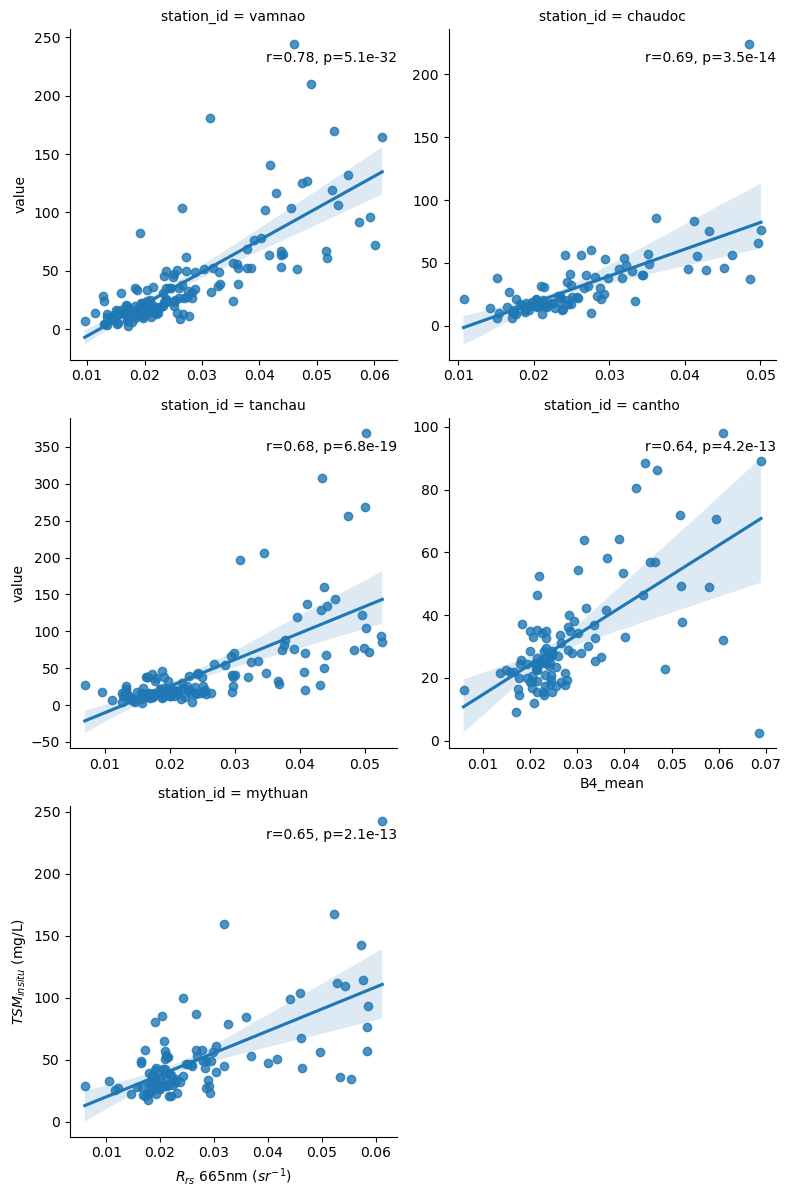

In [382]:
sns.set_style()

# Filter matchups
data = df_rs.loc[~np.isnan(df_rs.value)]
data = data.loc[data.platform.isin(platforms)]
data = data.loc[data.CLOUD_COVER<=thresh_cloud_cover]
#data = data.loc[data.cloudiness_2km_mean<=0.1]
data = data.loc[data.roi_coverage>=thresh_roi_coverage]

#data = data.loc[data.station_id=='vamnao']


data = data.loc[data[metric]>-0.2]


g = sns.lmplot(x=metric, y='value', data=data, 
               col='station_id', col_wrap=2,
               #hue='platform',
               #logx=True,
               #sharex=True, sharey=True,
               height=4,
               facet_kws={'sharey': False, 'sharex': False})

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['value'], data[metric])
    ax = plt.gca()
    ax.text(.6, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

plt.ylabel(r'$TSM_{insitu}$ (mg/L)')
plt.xlabel('$R_{rs}$ 665nm ($sr^{−1}$)')
#plt.ylabel(r'$TSM_{Nechad}$ (mg/L)')
#plt.title(f'Metric: {metric}')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

-0.06046775790258902 0.1802225297358595 0.09952619158291695
R² = 0.45036012079036347


Text(0.5, 0, '$GI_{TSS}$')

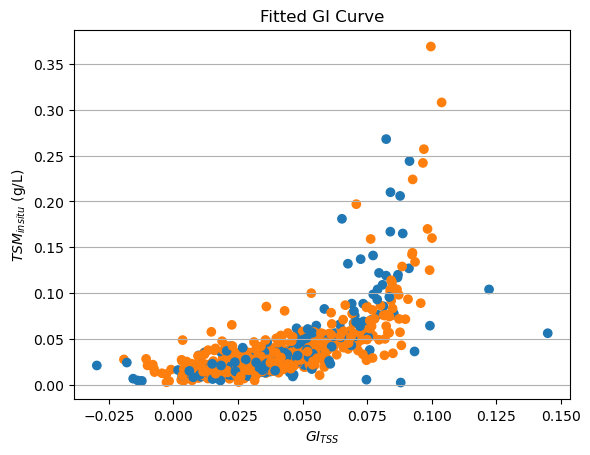

In [383]:
import scipy

def f_GI_tss(x, c0, c1, c2):
    Rb, Rg, Rr, Rnir = x
    w1 = Rr/(Rr+Rnir)
    w2 = Rnir/(Rr+Rnir)
    GI_tss = c0 * (Rg/Rb) + c1 * w1 * (Rr/Rg) + c2 * w2 * (Rnir/Rg)
    return GI_tss

# get data
Rb = data.B2_median.values
Rg = data.B3_median.values
Rr = data.B4_median.values
Rnir = data.apply(lambda x: x['B5_median'] if (str(x['platform']).split('-')[0] == 'LANDSAT') else x['B8_median'], axis=1)

x = (Rb, Rg, Rr, Rnir)
y = data.value/1000

p0 = (-0.05891038181763943, 0.18503702912285405, 0.0789243076198199)
bounds_h = (2, 2, 2)
bounds_l = (-2, -2, -2)

# perform the fit
params, cv = scipy.optimize.curve_fit(f_GI_tss, x, y, p0, bounds=(bounds_l, bounds_h), maxfev=10000000)
c0, c1, c2 = params
print(c0, c1, c2)

# determine quality of the fit
squaredDiffs = np.square(y - f_GI_tss(x, c0, c1, c2))
squaredDiffsFromMean = np.square(y - np.mean(y))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# Calculae GITTS
for idx, row in data.iterrows():
    platform = row.platform
    Rb = row.B2_median
    Rg = row.B3_median
    Rr = row.B4_median
    Rnir = row.B5_median if (platform.split('-')[0] == 'LANDSAT') else row.B8_median
    x = (Rb, Rg, Rr, Rnir)
    data.loc[idx, 'GI_tss'] = f_GI_tss(x, c0, c1, c2)
    df_rs.loc[idx, 'GI_tss'] = f_GI_tss(x, c0, c1, c2)
    
# plot the results
colors = list(data.platform.apply(lambda x: cmap(0) if x=='LANDSAT-8' else cmap(1)).values)
plt.grid(which='major', axis='y', zorder=-1.0)
plt.scatter(data.GI_tss.values, y, color=colors, label="data")
#plt.plot(data.sort_values('GI_tss').GI_tss, data.sort_values('GI_tss').GI_tss, 'k--', label="data")
plt.title("Fitted GI Curve")
plt.ylabel(r'$TSM_{insitu}$ (g/L)')
plt.xlabel(r'$GI_{TSS}$')

R² = 0.618352707132174, R = 0.7863540596526313
RMSE = 25.421604004322475


Text(0.5, 1.0, 'Fitted Exponential Curve (Two-term)')

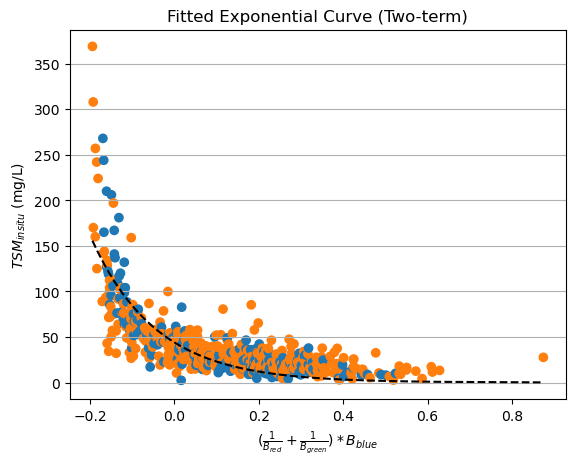

In [384]:
import scipy
from sklearn import metrics

def twoTermExp(x, a, b, c, d):
    return a*np.exp(b*x) + c*np.exp(d*x)

metric = 'add_ratio_rgb_median'
data = data.sort_values(metric)

# get data
xs = data[metric]
ys = data.value

# perform the fit
p0 = (2000, .1, 50, 0) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(twoTermExp, xs, ys, p0, maxfev=100000)
a, b, c, d = params

# determine quality of the fit
squaredDiffs = np.square(ys - twoTermExp(xs, a, b, c, d))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}, R = {np.sqrt(rSquared)}")
print(f'RMSE = {np.sqrt(metrics.mean_squared_error(ys, twoTermExp(xs, a, b, c, d)))}')

# plot the results
colors = list(data.platform.apply(lambda x: cmap(0) if x=='LANDSAT-8' else cmap(1)).values)
plt.grid(which='major', axis='y', zorder=-1.0)
plt.scatter(xs, ys, label="data", color=colors)
plt.plot(xs, twoTermExp(xs, a, b, c, d), 'k--', label="fitted")
plt.ylabel(r'$TSM_{insitu}$ (mg/L)')
plt.xlabel(r'$(\frac{1}{B_{red}}+\frac{1}{B_{green}})*B_{blue}$')
plt.title("Fitted Exponential Curve (Two-term)")

R² = 0.7305030738360423
RMSE = 21.36233711623719


Text(0.5, 1.0, 'Fitted Exponential Curve')

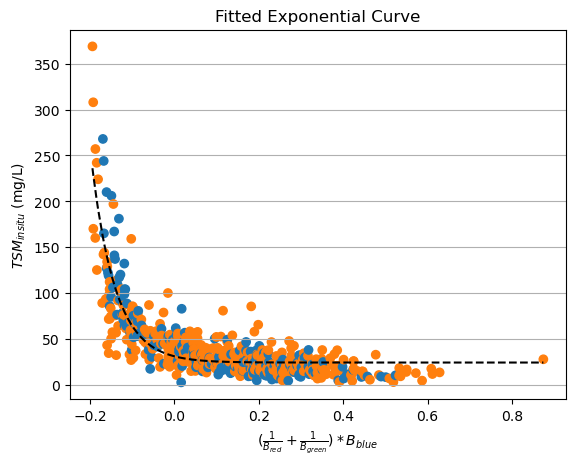

In [385]:
import scipy

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

metric = 'add_ratio_rgb_median'
data = data.sort_values(metric)

data = data.loc[data.value<400]

# get data
xs = data[metric]
ys = data.value

# perform the fit
p0 = (7, 18, 22) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, maxfev=100000)
m, t, b = params

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
print(f'RMSE = {np.sqrt(metrics.mean_squared_error(ys, monoExp(xs, m, t, b)))}')

# plot the results
colors = list(data.platform.apply(lambda x: cmap(0) if x=='LANDSAT-8' else cmap(1)).values)
plt.grid(which='major', axis='y', zorder=-1.0)
plt.scatter(xs, ys, label="data", color=colors)
plt.plot(xs, monoExp(xs, m, t, b), 'k--', label="fitted")
plt.ylabel(r'$TSM_{insitu}$ (mg/L)')
plt.xlabel(r'$(\frac{1}{B_{red}}+\frac{1}{B_{green}})*B_{blue}$')

plt.title("Fitted Exponential Curve")

### Correlation matrix

In [386]:
centerwl_lut_msi = {
    'B1':442.7, 'B2':492.4, 'B3':559.8, 'B4':664.6, 'B5':704.1, 'B6':740.5,'B7':782.8, 'B8':832.8, 'B8A':864.7, 'B9':945.1, 'B10':1373.5, 'B11':1613.7, 'B12':2202.4
}
centerwl_lut_oli = {
    'B1':442.96, 'B2':482.04, 'B3':561.41, 'B4':654.59, 'B5':864.67, 'B6':1608.86, 'B7':2200.73,'B8':590,'B9':1375,'B10':10800,'B11':1200  
}

In [387]:
# Prepare data
thresh_cloud_cover = 50
thresh_roi_coverage = 90
data = df_rs.copy()
#data = data.drop(columns=)
data = data.loc[data.CLOUD_COVER<=thresh_cloud_cover]
data = data.loc[data.roi_coverage>=thresh_roi_coverage]
data_msi = data.loc[data.platform=='SENTINEL-2']
data_msi = data_msi[data_msi.columns[((data_msi.columns.str.startswith('B'))&(data_msi.columns.str.endswith('_median')))|(data_msi.columns=='value')]]
data_oli = data.loc[data.platform=='LANDSAT-8']
data_oli = data_oli[data_oli.columns[((data_oli.columns.str.startswith('B'))&(data_oli.columns.str.endswith('_median')))|(data_oli.columns=='value')]]

# Compute a correlation matrix and convert to long-form
corr_mat = data_msi.corr().stack().reset_index(name="correlation")
corr_mat = corr_mat.loc[corr_mat.level_0=='value'].reset_index().drop(columns=['level_0', 'index']).rename(columns={'level_1': 'band'})
corr_mat_msi = corr_mat.loc[corr_mat.band!='value']
corr_mat_msi['band'] = corr_mat_msi.band.apply(lambda x: x.split('_')[0])
corr_mat_msi['wavelength'] = corr_mat_msi.band.apply(lambda x: centerwl_lut_msi[x])
corr_mat_msi = corr_mat_msi.sort_values('wavelength')

corr_mat = data_oli.corr().stack().reset_index(name="correlation")
corr_mat = corr_mat.loc[corr_mat.level_0=='value'].reset_index().drop(columns=['level_0', 'index']).rename(columns={'level_1': 'band'})
corr_mat_oli = corr_mat.loc[corr_mat.band!='value']
corr_mat_oli['band'] = corr_mat_oli.band.apply(lambda x: x.split('_')[0])
corr_mat_oli['wavelength'] = corr_mat_oli.band.apply(lambda x: centerwl_lut_oli[x])
corr_mat_oli = corr_mat_oli.sort_values('wavelength')

hline = hv.HLine(0).opts(
    color='grey', 
    line_dash='dashed', 
    line_width=1.0,
)

clim = (-1, 1)

plot_msi =  hline *\
            corr_mat_msi.hvplot.line(x='wavelength', y='correlation', clim=clim) *\
            corr_mat_msi.hvplot.scatter(x='wavelength', y='correlation', 
                xlabel='Wavelength (nm)', ylabel="Correlation\n(Pearson's R)",
                color='correlation', size=100, clim=clim, cmap='bwr',
                title='Sentinel-2 - Rrs-TSM correlation',
                line_color='black',
                xlim=(400,1500), rot=45) * \
            corr_mat_msi.hvplot.labels(x='wavelength', y='correlation', text='band', text_baseline='top')

plot_oli =  hline *\
            corr_mat_oli.hvplot.line(x='wavelength', y='correlation', clim=clim) *\
            corr_mat_oli.hvplot.scatter(x='wavelength', y='correlation', 
                xlabel='Wavelength (nm)', ylabel="Correlation\n(Pearson's R)",
                color='correlation', size=100, clim=clim, cmap='bwr',
                title='Landsat-8 OLI - Rrs-TSM correlation',
                line_color='black',
                xlim=(400,1500), rot=45) * \
            corr_mat_oli.hvplot.labels(x='wavelength', y='correlation', text='band', text_baseline='top')

hv.Layout([plot_msi, plot_oli]).cols(1).opts(hv.opts.Scatter(clim=(-1, 1)))

C:\Users\Michael\AppData\Local\Temp\ipykernel_24516\4006637458.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_msi['band'] = corr_mat_msi.band.apply(lambda x: x.split('_')[0])
C:\Users\Michael\AppData\Local\Temp\ipykernel_24516\4006637458.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_msi['wavelength'] = corr_mat_msi.band.apply(lambda x: centerwl_lut_msi[x])
C:\Users\Michael\AppData\Local\Temp\ipykernel_24516\4006637458.py:24: SettingWithCopyWarning: 
A value is trying to be set

:Layout
   .Overlay.I  :Overlay
      .HLine.I   :HLine   [x,y]
      .Curve.I   :Curve   [wavelength]   (correlation)
      .Scatter.I :Scatter   [wavelength]   (correlation)
      .Labels.I  :Labels   [wavelength,correlation]   (band)
   .Overlay.II :Overlay
      .HLine.I   :HLine   [x,y]
      .Curve.I   :Curve   [wavelength]   (correlation)
      .Scatter.I :Scatter   [wavelength]   (correlation)
      .Labels.I  :Labels   [wavelength,correlation]   (band)

## Random forest

Training Features Shape: (472, 107)
Training Labels Shape: (472,)
Testing Features Shape: (119, 107)
Testing Labels Shape: (119,)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    2.6s


Mean Absolute Error: 14.25 mg/L.
Accuracy: 56.83 %.
Mean Absolute Error (MAE): 14.254925210084034
Mean Squared Error (MSE): 620.8354281558824
Root Mean Squared Error (RMSE): 24.91656934964929
Mean Absolute Percentage Error (MAPE): 43.17
Accuracy: 56.83


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Text(0.5, 1.0, 'RF validation')

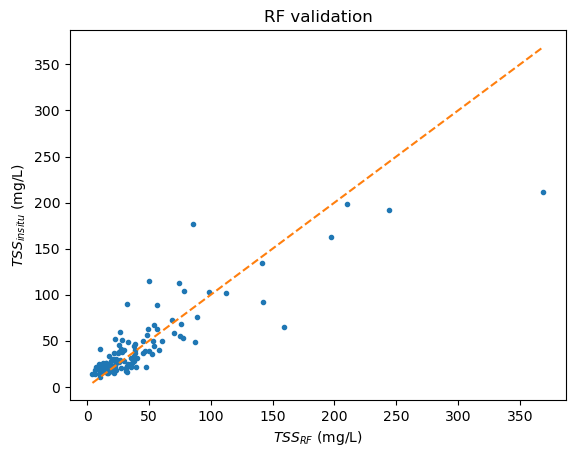

In [391]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

platform = ['LANDSAT-8', 'LANDSAT-9']
platform = ['SENTINEL-2']
platform = ['LANDSAT-8', 'LANDSAT-9', 'SENTINEL-2']


features = df_rs.copy()

# filter data
features = features.loc[features.CLOUD_COVER<=80]
features = features.loc[features.roi_coverage>=75]
features = features.loc[~np.isnan(features.value)]
features = features.loc[features.platform.isin(platform)]
#features = features.loc[features.data_source=='mrc']

# get quantile bins for stratified sampling
features['q_bin'] = pd.qcut(features['value'], q=10)
qbins = np.array(features['q_bin'])
# features = features[features.columns[(features.columns.str.startswith('B'))| \
#                                      (features.columns=='value')| \
#                                      (features.columns.str.startswith('bratio'))]]
#features = features[features.columns[(features.columns.str.startswith('B'))|(features.columns=='value')]]
#features = features[features.columns[(features.columns.str.endswith('_median'))|(features.columns=='value')]]
features = features.drop(columns=['system:index', 'data_source', 'platform', 'station_id', 
                                  'dt_utc', 'dt_loc', 'dt_diff', 'date', 'dt_loc_insitu', 'q_bin'], errors='ignore')
features = features.dropna(axis=1)

# Labels are the values we want to predict
labels = np.array(features['value'])
# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size=0.20, 
                                                                            stratify=qbins, 
                                                                            random_state=42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1, verbose=True)
# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'mg/L.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_labels, predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_labels, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))
mape = np.mean(np.abs((test_labels - predictions) / np.abs(test_labels)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

# plot the results
plt.plot(test_labels, predictions, '.', label="data")
plt.plot(sorted(test_labels), sorted(test_labels), '--', label="1:1")
plt.ylabel('$TSS_{insitu}$ (mg/L)')
plt.xlabel('$TSS_{RF}$ (mg/L)')
plt.title("RF validation")

## Feature importance based on mean decrease in impurity

Elapsed time to compute the importances: 0.128 seconds


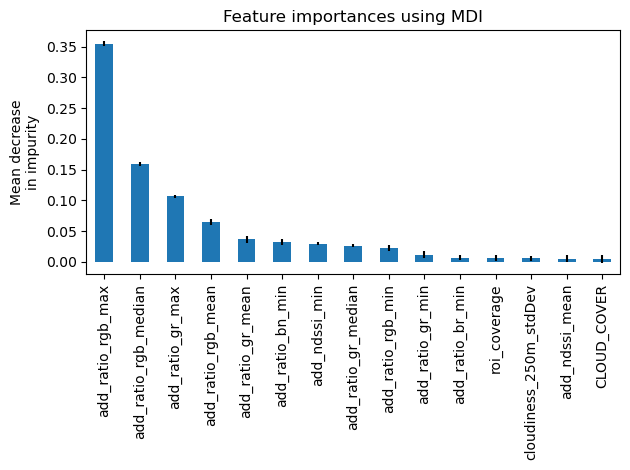

In [399]:
import pandas as pd
import time

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_list).sort_values(ascending=False).iloc[:30]

lim = 15
fig, ax = plt.subplots()
forest_importances.iloc[:lim].plot.bar(yerr=std[:lim], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease\nin impurity")
fig.tight_layout()

## Feature importance based on feature permutation

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Elapsed time to compute the importances: 51.737 seconds


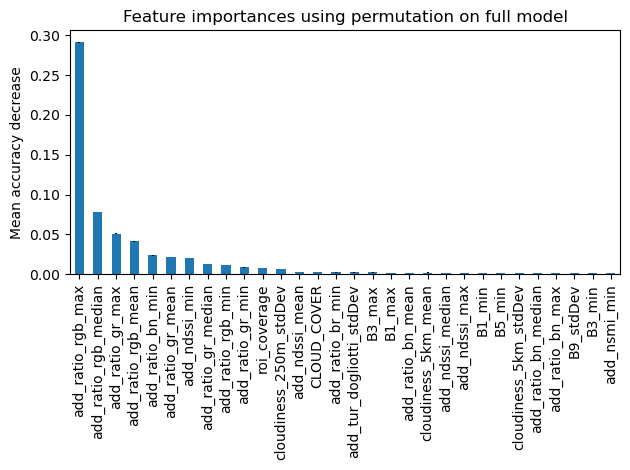

In [400]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf, features, labels, n_repeats=10, random_state=42, n_jobs=-1,
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_list).sort_values(ascending=False)

lim = 15
fig, ax = plt.subplots()
forest_importances.iloc[:lim].plot.bar(yerr=result.importances_std[:lim], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()